In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.multiclass import unique_labels
import kenlm


%matplotlib notebook


In [2]:
PATH_TRAIN_J = '../../../../data/raw/Oscar_data/PP/pp_train_adult_2634.json'
PATH_TRAIN_T = '../../../../data/raw/Oscar_data/PP/pp_train_adult_2634.txt'
PATH_VAL_J = '../../../../data/raw/Oscar_data/PP/pp_val_adult_829.json'
PATH_TEST_J = '../../../../data/raw/Oscar_data/PP/pp_test_adult_829.json'

PATH_MODEL_MINI = '../../../../models/English/PP_approach/kenlm_mini.binary'




# 1. Choose Perplexity Thresholds for the  Harmful Model

In [3]:
def pp(log_score, length):
    return 10.0 ** (-log_score / length)

In [4]:
def get_pp (df, model):
    ls_pp = []
    for i, text in enumerate(df['text']):
        log_score = model.score(text, bos = True, eos = True)
        n = len(text.split())

        if n==0:
            ls_pp.append(0)
        else:
            ls_pp.append(pp(log_score, n))
    df['pp_score'] = ls_pp
    return (df)

In [5]:
def distributions_pp (df):
    print('---- 1 -----')
    display(df[df['annotation']==1].describe().transpose().round(2))
    print('\n---- 0 -----')
    display(df[df['annotation']==0].describe().transpose().round(2))


    sns.displot(df[['pp_score', 'annotation']], x="pp_score", hue="annotation", kind="kde", palette="PRGn")
    plt.show()
    
    plt.figure()
    sns.boxplot(x='annotation', y='pp_score', data=df[['annotation', 'pp_score']], palette="PRGn")
    plt.show()

In [6]:
df_val = pd.read_json(PATH_VAL_J)
df_val.reset_index(inplace=True, drop=True)
df_test = pd.read_json(PATH_TEST_J)
df_test.reset_index(inplace=True, drop=True)


In [7]:
# Get harmful model
model_kenlm = kenlm.Model(PATH_MODEL_MINI)

Perplexity score estimation takes: 3.44 seconds


,text,annotation,pp_score
0,#ubuntu-qc 2011-09-05\n<qwebirc43563> BOnjours...,0,136306.340204
1,Anime is a phenomenon that has taken off like ...,1,1024.710015
2,Vasoconstrictive effects of human post-hemorrh...,0,9790.022533
3,Numerous infants born to women consuming foods...,0,8104.352443
4,A nonsurgical approach to low back pain.\nLow ...,0,6850.865305


---- 1 -----


,count,mean,std,min,25%,50%,75%,max
annotation,329.0,1.00,0.00,1.00,1.00,1.00,1.00,1.00
pp_score,329.0,1965.68,2031.81,1.47,862.51,1588.82,2604.13,18392.81



---- 0 -----


,count,mean,std,min,25%,50%,75%,max
annotation,500.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00
pp_score,500.0,47053.96,133169.4,0.0,2960.16,6041.88,15494.73,1071815.65


<IPython.core.display.Javascript object>


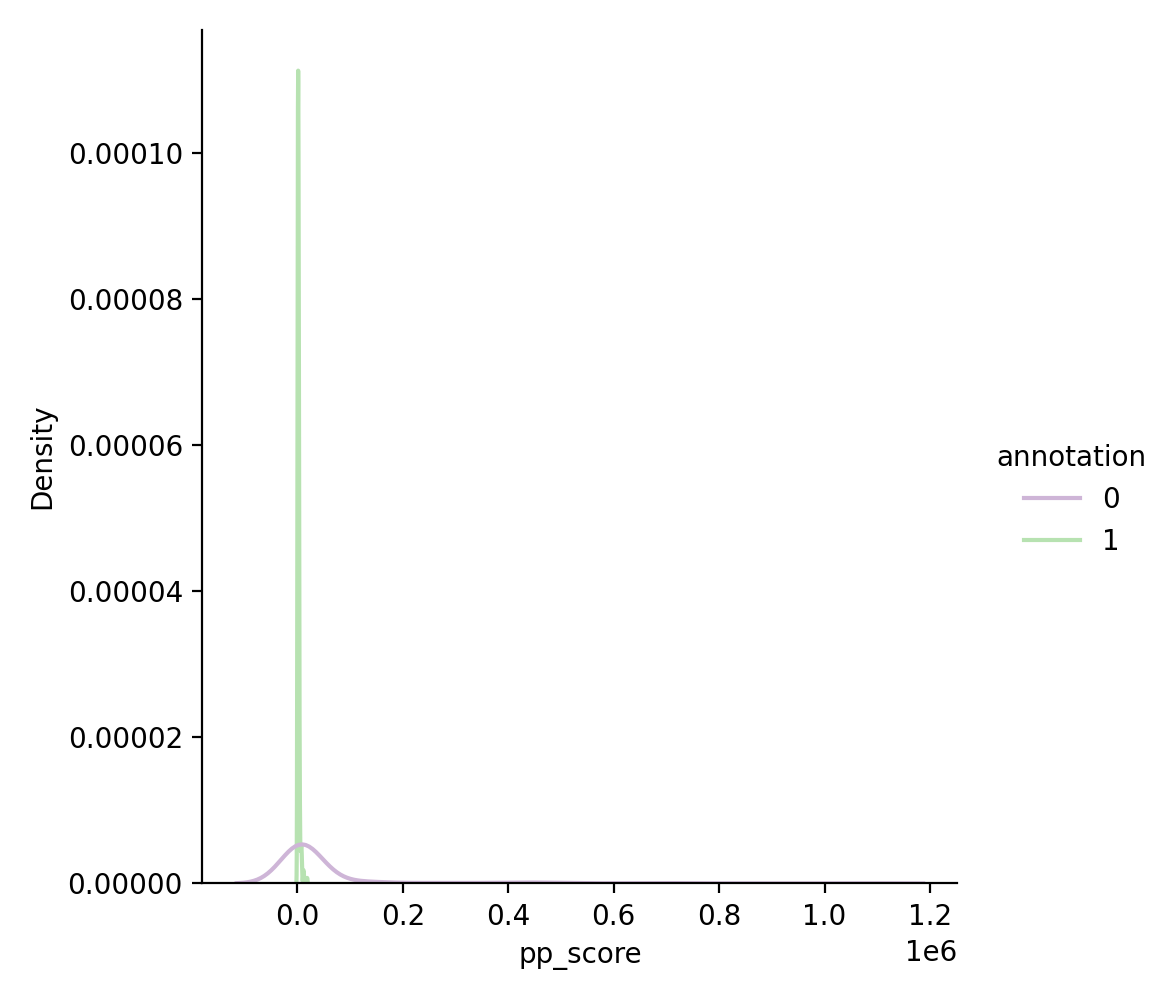

<IPython.core.display.Javascript object>


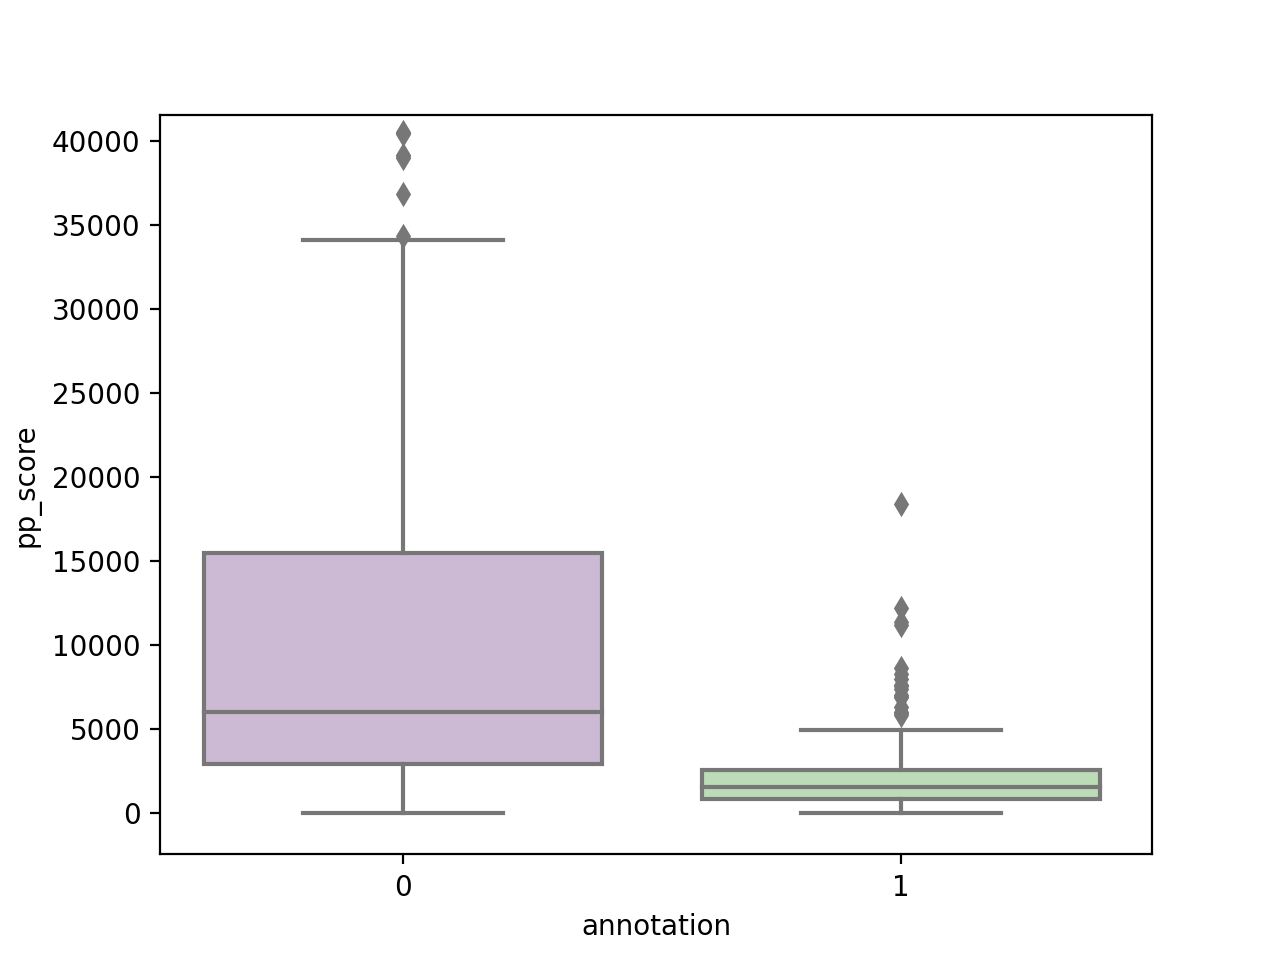

In [8]:
start_time = time.time()
df_val = get_pp (df_val, model_kenlm)
print("Perplexity score estimation takes: %s seconds" %round(time.time() - start_time, 2))
display(df_val.head())
distributions_pp (df_val)

The perplexity threshold must be between [0 - 18392] (min of non_harmful and max of harmful)

In [9]:
def get_thresholds (df, n):
    mi = min(df[df['annotation']==0]['pp_score'])
    ma = max(df[df['annotation']==1]['pp_score'])
    s = (ma - mi)/n

    ls_threshold = [mi]
    for i in range (n):
        mi = mi + s
        ls_threshold.append (mi)
    ls_threshold = [round(i, 4) for i in ls_threshold]
    return (ls_threshold)

In [10]:
def metrics_thresholds (df, n, model):
    
    ls_f1_0 = []
    ls_f1_1 = []
    ls_p_macro = []
    ls_r_macro = []
    ls_f1_macro = []
    ls_accuracy = []
    
    # Calculate perplexity score
    df = get_pp (df, model)

    # Calculate classification metrics for the perplexity thresholds
    ls_threshold = get_thresholds (df, n)
    for thre in ls_threshold:
        pred = np.where(df['pp_score'] >= thre, 0, 1)
        
        ls_f1_0.append( f1_score(df['annotation'], pred, pos_label=0) )
        ls_f1_1.append( f1_score(df['annotation'], pred) )
        ls_p_macro.append( precision_score(df['annotation'], pred, average='macro') )
        ls_r_macro.append( recall_score(df['annotation'], pred, average='macro') )
        ls_f1_macro.append( f1_score(df['annotation'], pred, average='macro') )
        ls_accuracy.append( accuracy_score(df['annotation'], pred) )
        #print(classification_report(df['annotation'], pred))
        
    
    # Create df with the metrics
    df_metrics = pd.DataFrame({'accuracy':ls_accuracy, 'f1_macro':ls_f1_macro, 'precision_macro':ls_p_macro, 
                               'recall_macro':ls_r_macro, 'f1_0':ls_f1_0, 'f1_1':ls_f1_1}, index=ls_threshold)
    
    # Plot metrics for the thresholds
    plt.figure()
    sns.lineplot(data=df_metrics[['accuracy', 'f1_0', 'f1_1', 'f1_macro', 'accuracy']], palette="PRGn")
    plt.xlabel('perplexity_score')
    plt.ylabel('metrics_values')
    plt.show()
    
    df_metrics.reset_index(inplace = True)
    print('The best perplexity score is:\n',df_metrics.iloc[df_metrics['f1_macro'].idxmax()])
    return (df_metrics)
    

/Users/victoriazevallos/anaconda3/envs/snake8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>


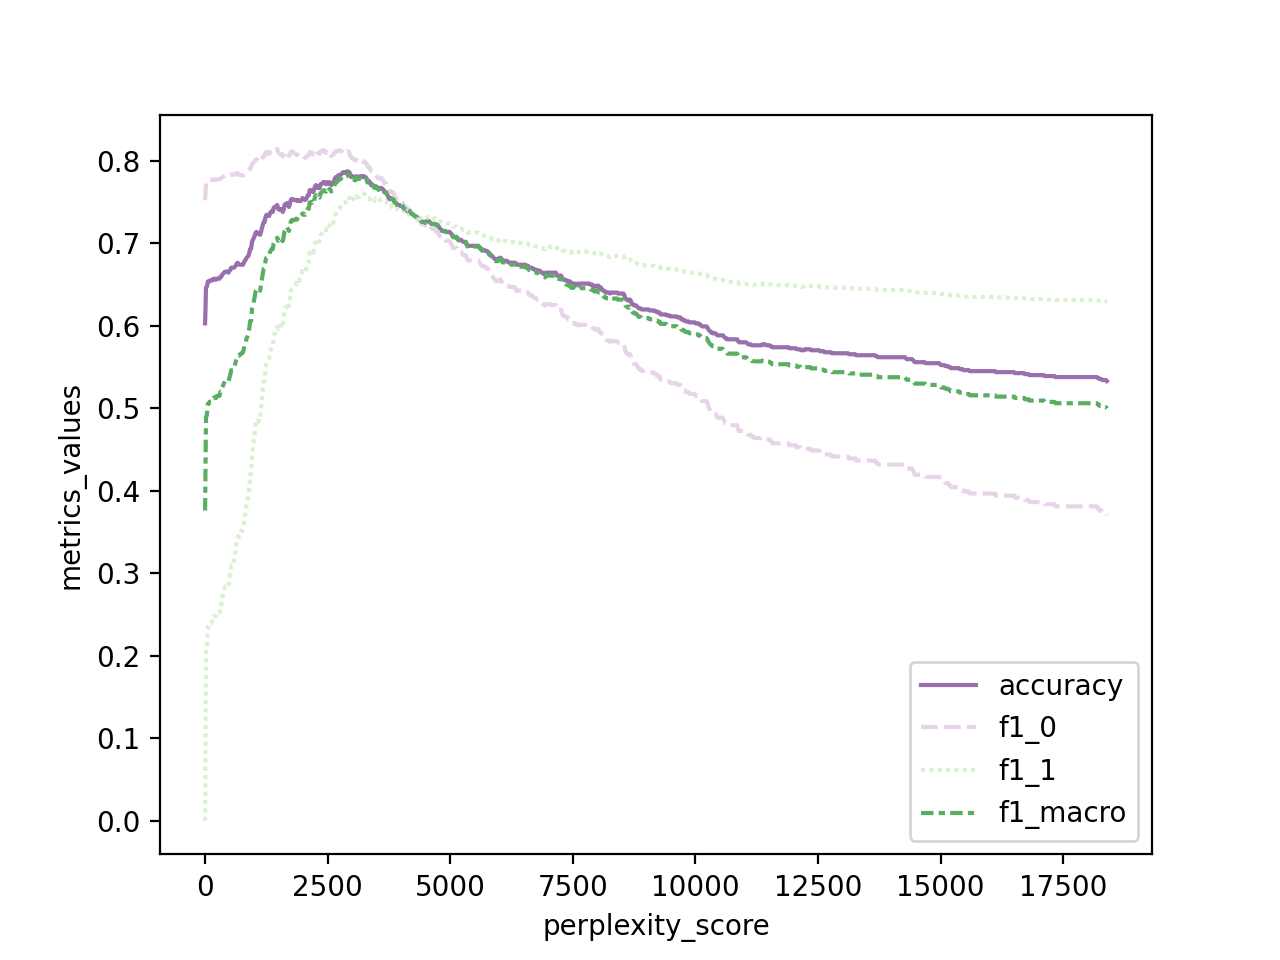

The best perplexity score is:
 index              2906.064600
accuracy              0.787696
f1_macro              0.784099
precision_macro       0.783108
recall_macro          0.794894
f1_0                  0.811966
f1_1                  0.756233
Name: 158, dtype: float64


In [11]:
df_metrics = metrics_thresholds (df_val, 1000, model_kenlm)

As perplexity thresholds, we choose: 1452, 2906, 4545. Even though the best performance is reached with 2906, we still want to avoid overfitting and therefore we select the other thresholds as well.

# 2. Performance of the 3 Selected Thresholds on the Validation Set

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [13]:

def evaluation(thresholds, df, model):
    
    # Calculate perplexity score
    df = get_pp (df, model)
    
    # Evaluation
    plt.figure(figsize=(9,5))
    for i, thre in enumerate(thresholds):
        pred = np.where(df['pp_score'] >= thre, 0, 1)
        
        print('--------- perplexity threshold = %s -----------'%thre)
        print(classification_report(df['annotation'], pred))
        
        plt.subplot(1,3,i+1)
        cm = confusion_matrix(df['annotation'], pred)
        plot_confusion_matrix(cm, classes = unique_labels(df['annotation']), title = "Threshold = %s"%thre)


<IPython.core.display.Javascript object>


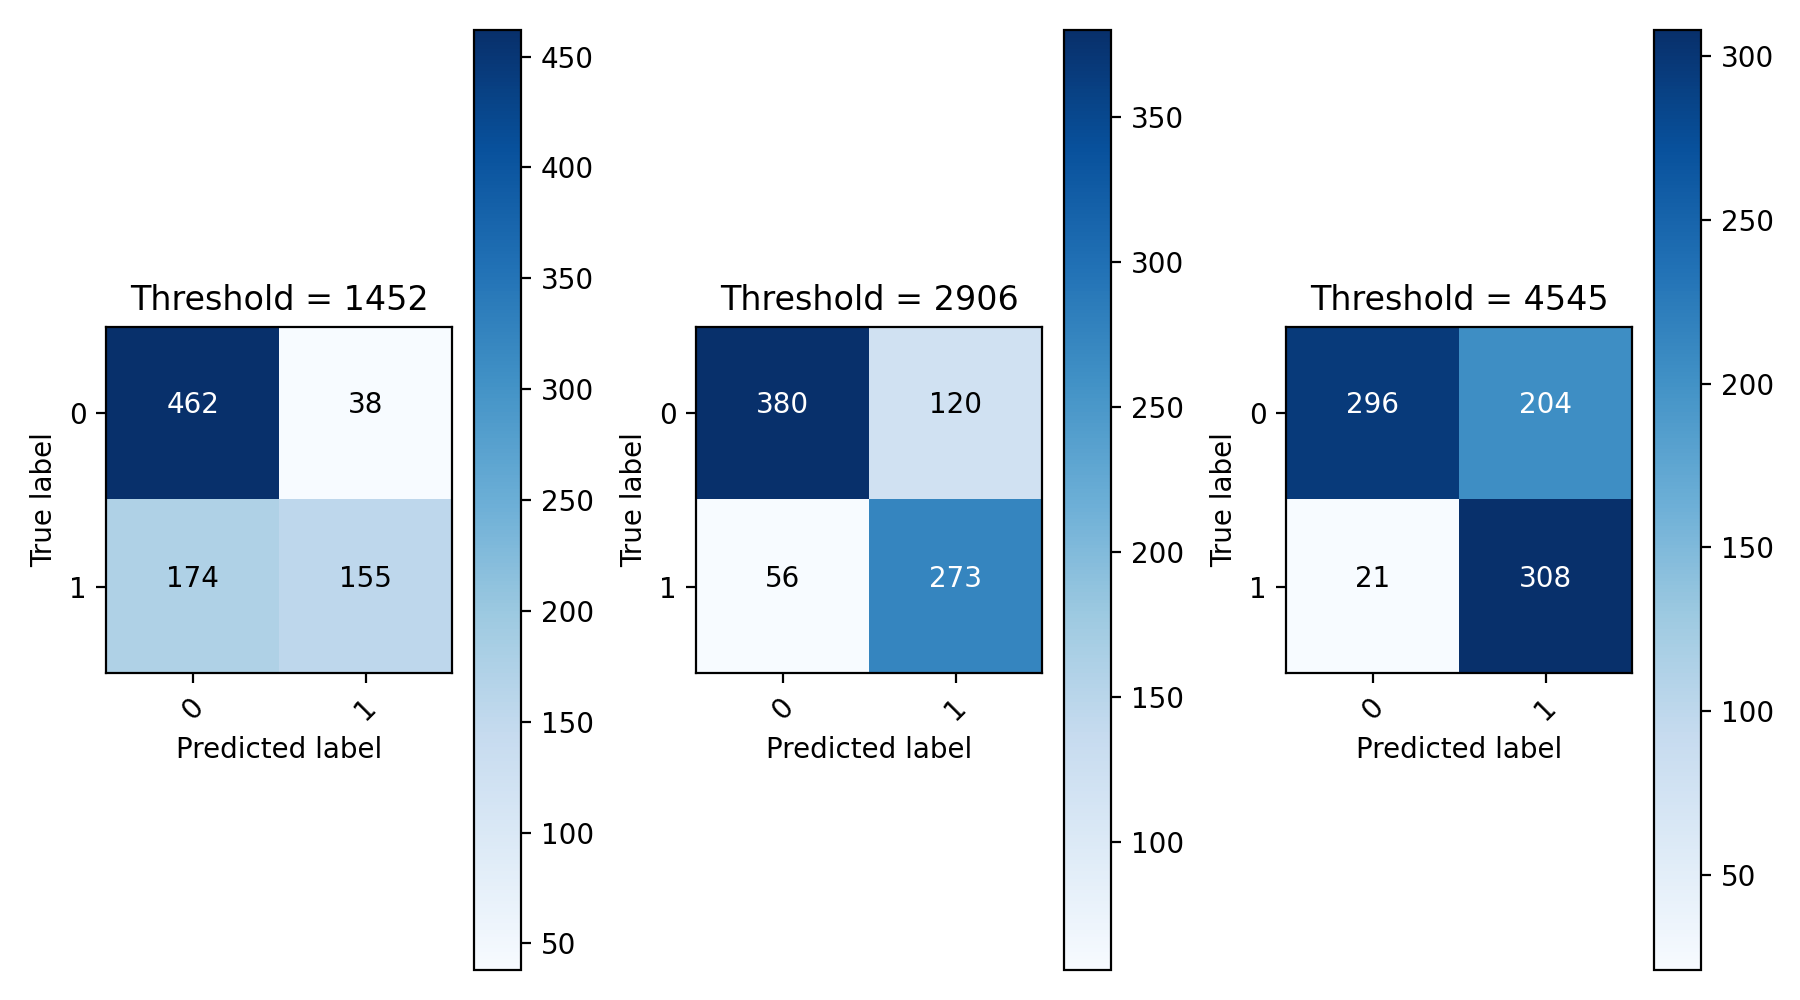

--------- perplexity threshold = 1452 -----------
              precision    recall  f1-score   support

           0       0.73      0.92      0.81       500
           1       0.80      0.47      0.59       329

    accuracy                           0.74       829
   macro avg       0.76      0.70      0.70       829
weighted avg       0.76      0.74      0.73       829

--------- perplexity threshold = 2906 -----------
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       500
           1       0.69      0.83      0.76       329

    accuracy                           0.79       829
   macro avg       0.78      0.79      0.78       829
weighted avg       0.80      0.79      0.79       829

--------- perplexity threshold = 4545 -----------
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       500
           1       0.60      0.94      0.73       329

    accuracy                    

In [14]:
evaluation([1452, 2906, 4545], df_val, model_kenlm)

# 3. Performance of the 3 Selected Thresholds on the Test Set

<IPython.core.display.Javascript object>


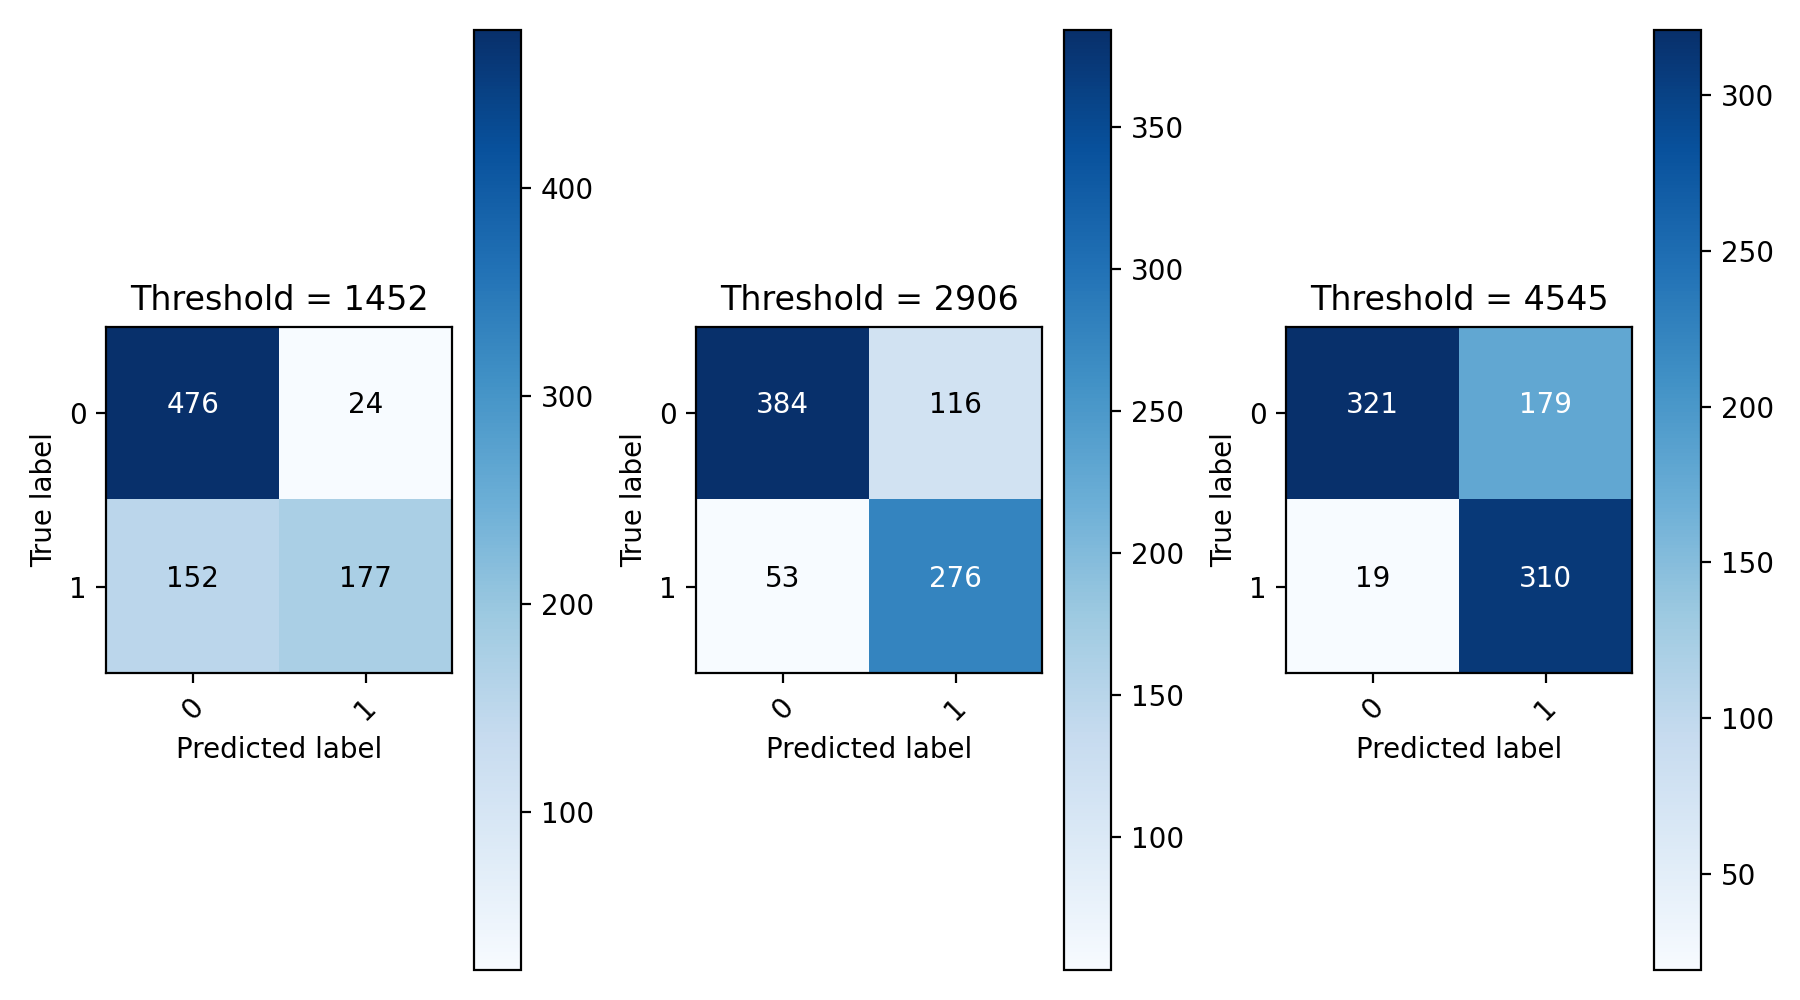

--------- perplexity threshold = 1452 -----------
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       500
           1       0.88      0.54      0.67       329

    accuracy                           0.79       829
   macro avg       0.82      0.74      0.76       829
weighted avg       0.81      0.79      0.77       829

--------- perplexity threshold = 2906 -----------
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       500
           1       0.70      0.84      0.77       329

    accuracy                           0.80       829
   macro avg       0.79      0.80      0.79       829
weighted avg       0.81      0.80      0.80       829

--------- perplexity threshold = 4545 -----------
              precision    recall  f1-score   support

           0       0.94      0.64      0.76       500
           1       0.63      0.94      0.76       329

    accuracy                    

In [15]:
evaluation([1452, 2906, 4545], df_test, model_kenlm)

,text,annotation,pp_score
0,1. Field of the Invention\nThe present inventi...,0,4607.550898
1,247CoupleCams.com – One place for the collecti...,1,4.828216
2,Epidemia de gripe (debate) \nPresidente\nSegue...,0,223389.604669
3,The most random thing happened to me on Sunday...,1,1954.448474
4,Gustavo Cañete\n\nGustavo Cañete (born April 4...,0,171762.800343


---- 1 -----


,count,mean,std,min,25%,50%,75%,max
annotation,329.0,1.00,0.00,1.00,1.0,1.00,1.00,1.0
pp_score,329.0,1738.33,2319.46,1.36,629.1,1314.29,2304.01,33576.6



---- 0 -----


,count,mean,std,min,25%,50%,75%,max
annotation,500.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00
pp_score,500.0,114947.77,834583.6,0.0,3161.08,6438.12,17113.67,17481780.34


<IPython.core.display.Javascript object>


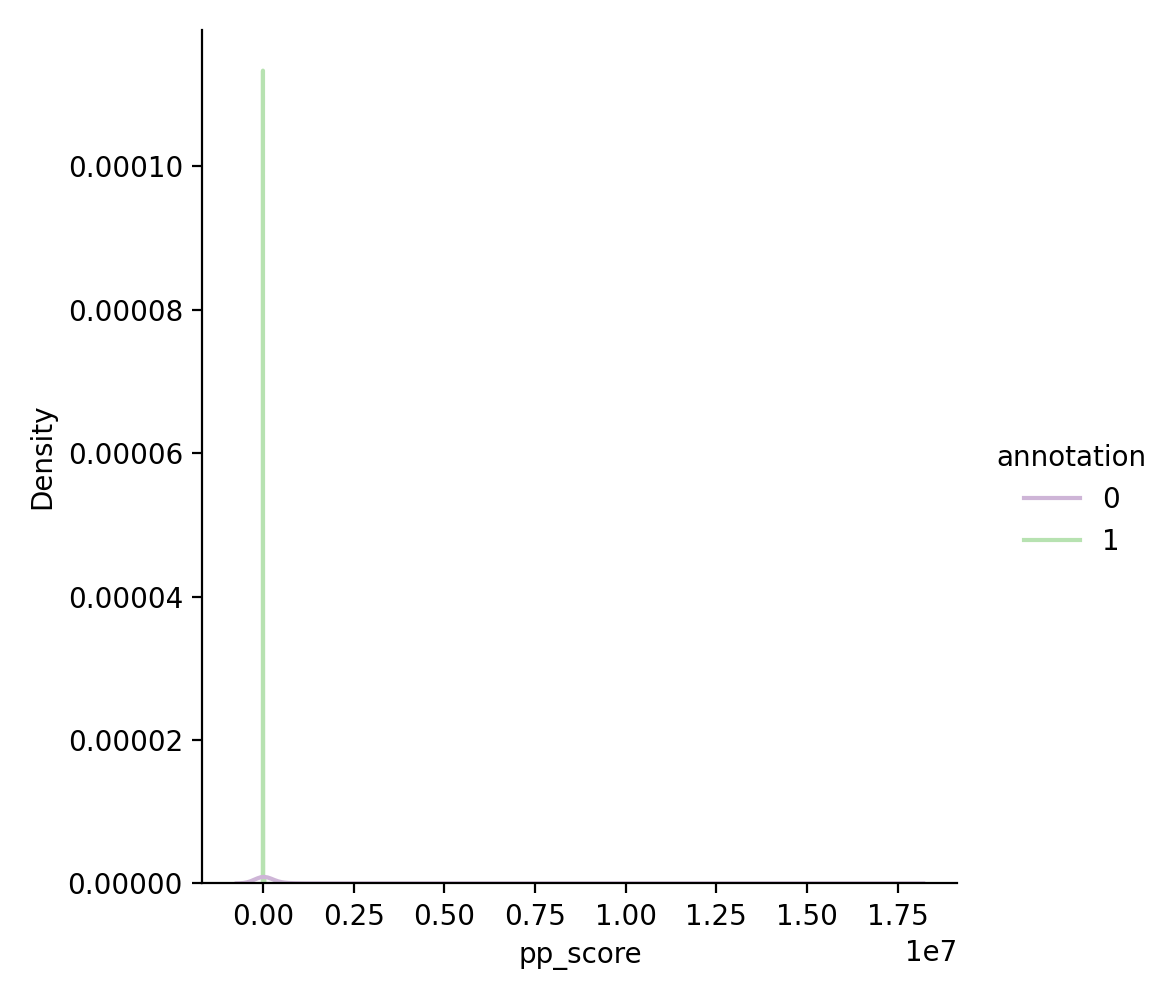

<IPython.core.display.Javascript object>


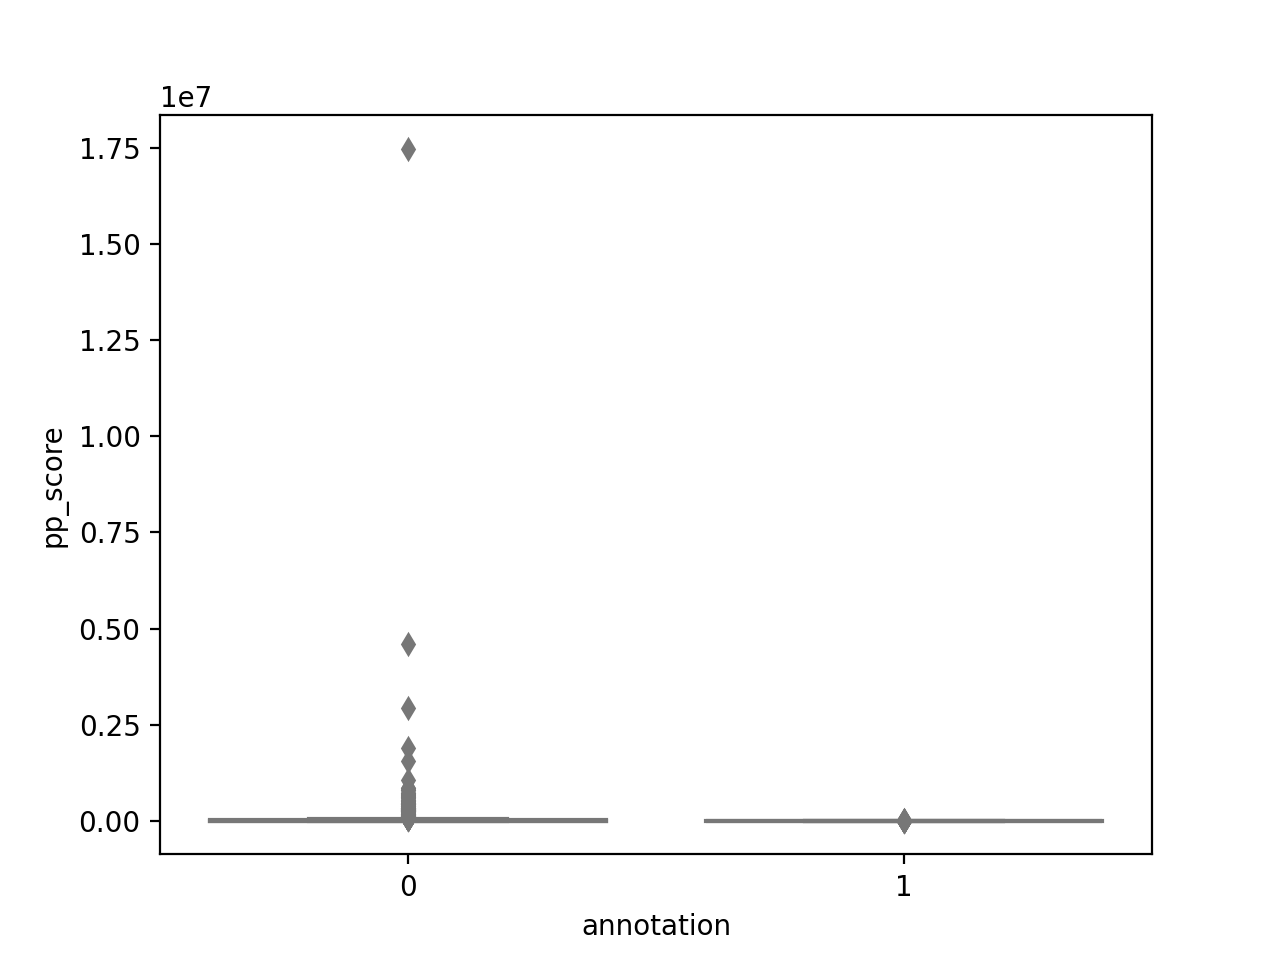

In [16]:
df_test = get_pp (df_test, model_kenlm)
display(df_test.head())
distributions_pp (df_test)